# Chuẩn hóa 
- Tác dụng:
    + Giảm sự tác động do sự khác biệt về quy mô của các feature đầu vào. 
    + Cải thiện sự hội tụ bằng cách giữ các trọng số và hàm kích hoạt trong phạm vi hợp lý, giảm hiện tượng gradient quá nhỏ hoặc quá lớn gây ảnh hưởng đến quá trình tối ưu
    + Cải thiện khả năng khái quát hóa mô hình bằng cách giảm overfitting

# Batch Normalization
Chuẩn hóa dữ liệu cho mỗi batch dữ liệu đầu vào
$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B ^ 2 + \epsilon}}
$$

Trong đó:
+ $\epsilon$: tránh mẫu số bằng 0


Nhược điểm:
+ Làm chậm quá trình đào tạo vì quá trình chuẩn hóa theo từng lô
+ Các lô nhỏ có thể không cung cấp đầu đủ thông tin để ước lượng chính xác và độ lệch chuẩn

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [75]:
means = [[8, 2],
         [10, 4]]

cov = [[1, 0.4],
       [0.4, 1]]

N = 400
num_class = 2

X0 = np.random.multivariate_normal(size=N, mean=means[0], cov=cov)
X1 = np.random.multivariate_normal(size=N, mean=means[1], cov=cov)

X = np.concatenate((X0, X1), axis=0)
y = np.concatenate((np.zeros(N), np.ones(N)))
    

In [76]:
st = StandardScaler()

X_nor = st.fit_transform(X)

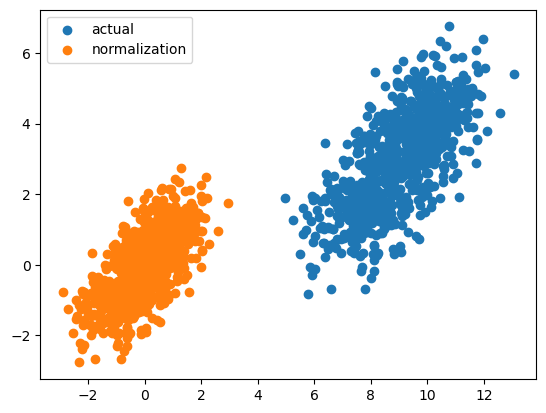

In [77]:
actual = plt.scatter(X[:,0], X[:,1])
nor = plt.scatter(X_nor[:,0], X_nor[:,1])

plt.legend((actual, nor),
           ('actual', 'normalization'))

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [84]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.z1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch Normalization
        self.z2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  # Batch Normalization
        self.z3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.z1(x))
        x = F.relu(self.z2(x))
        x = self.z3(x)
        return x

In [85]:
num_sample, input_size = X_train.shape
hidden_size = 100
output_size = 2
batch_sizes = [4, 8, 12, 24, 32]
num_epochs = [20, 40, 80, 100, 200, 500]


def train(num_epoch, batch_size):
    device = torch.device('cpu')
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLP(input_size, hidden_size, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.001)

    for epoch in range(num_epoch):
        for X_batch, y_batch in train_dataloader:
            batch_X, batch_y = X_batch.to(device), y_batch.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass và tối ưu hóa
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        test_X, test_y = torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long)
        outputs = model(test_X)
        _, predicted = torch.max(outputs, 1)
        
        accuracy = (predicted == test_y).sum().item() / test_y.size(0)
    
        return 1 - accuracy


In [86]:
errors = []
for batch_size in batch_sizes:
    error = []
    for num_epoch in num_epochs:
        error.append(train(num_epoch, batch_size))
    errors.append(error)

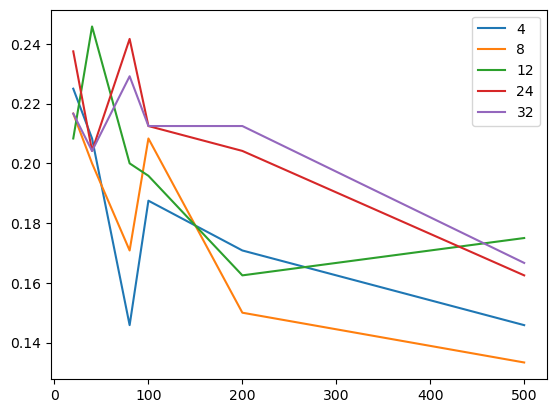

In [87]:
for error, batch_size in zip(errors, batch_sizes):
    plt.plot(num_epochs, error, label=batch_size)

plt.legend(loc="upper right")